In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.corpus import stopwords
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ROCAUC

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\themi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\themi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\themi\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [2]:
tweets_df = pd.read_csv("data\\data.csv")
tweets_df

,Sl no,Tweets,Search key,Feeling
0,1,"#1: @fe ed ""RT @MirayaDizon1: Time is ticking...",happy moments,happy
1,2,"#2: @蓮花 &はすか ed ""RT @ninjaryugo: ＃コナモンの日 だそうで...",happy moments,happy
2,3,"#3: @Ris ♡ ed ""Happy birthday to one smokin h...",happy moments,happy
3,4,"#4: @월월 [씍쯴사랑로봇] jwinnie is the best, cheer u...",happy moments,happy
4,5,"#5: @Madhurima wth u vc♥ ed ""Good morning dea...",happy moments,happy
...,...,...,...,...
10012,10016,"Tweet #85: @Matteo tweeted ""@GameSpot @Frannkc...",irritating,angry
10013,10017,"Tweet #86: @𝐚𝐧𝐢𝐬𝐭𝐨𝐧 tweeted ""@BRATgiirl_ that’...",irritating,angry
10014,10018,"Tweet #87: @Chowkidar Ricky Sharma tweeted ""@M...",irritating,angry
10015,10019,"Tweet #88: @Katoe.EXE tweeted ""u know what i h...",irritating,angry


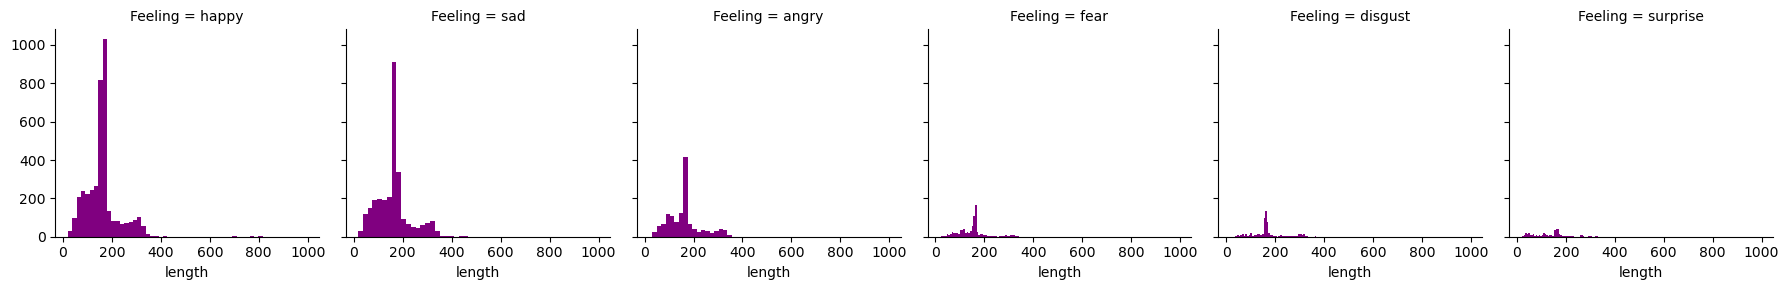

In [3]:
tweets_df.describe(include='all')
tweets_df['length'] = tweets_df['Tweets'].apply(len)
tweets_df.head()
graph = sns.FacetGrid(data=tweets_df,col='Feeling')
graph.map(plt.hist,'length',bins=50,color='Purple')

# Text preprocessing

In [4]:


def remove_url(text):
    return re.sub(r"http\S+", "", text)

def remove_punctuation(text):
    """Remove punctuation"""
    translator = str.maketrans("","",string.punctuation)
    return text.translate(translator)

stop = set(stopwords.words("english"))
def remove_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)

def remove_numbers(text):
    filtered_words = [i for i in text.split() if not i.isdigit()]
    return " ".join(filtered_words)

stop_words = ["ed","rt","tweet","tweeted"]
def remove_freq(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop_words]
    return " ".join(filtered_words)

def remove_non_latin(text):
    return re.sub(r'[^\x00-\x7F]+','', text)



In [5]:
tweets_df['Tweets'] = tweets_df['Tweets'].apply(remove_url)
tweets_df['Tweets'] = tweets_df['Tweets'].apply(remove_punctuation)
tweets_df['Tweets'] = tweets_df['Tweets'].apply(remove_stopwords)
tweets_df['Tweets'] = tweets_df['Tweets'].apply(remove_numbers)
tweets_df['Tweets'] = tweets_df['Tweets'].apply(remove_freq)
tweets_df['Tweets'] = tweets_df['Tweets'].apply(remove_non_latin)
tweets_df['Tweets'] = tweets_df['Tweets'].str.replace('\d+', '')


C:\Users\themi\AppData\Local\Temp\ipykernel_8548\3553757113.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets_df['Tweets'] = tweets_df['Tweets'].str.replace('\d+', '')


In [6]:
# Use English stemmer.
stemmer = SnowballStemmer("english")

tweets_df['tokenized'] = tweets_df.apply(lambda row: nltk.word_tokenize(row['Tweets']), axis=1)
tweets_df['stemmed'] = tweets_df['tokenized'].apply(lambda x: [stemmer.stem(y) for y in x])
tweets_df['stemmed'] = tweets_df.apply(lambda row: TreebankWordDetokenizer().detokenize(row['stemmed']), axis=1)

In [7]:
tweets_df

,Sl no,Tweets,Search key,Feeling,length,tokenized,stemmed
0,1,fe mirayadizon time ticking fast relive past h...,happy moments,happy,152,"[fe, mirayadizon, time, ticking, fast, relive,...",fe mirayadizon time tick fast reliv past happi...
1,2,ninjaryugo,happy moments,happy,107,[ninjaryugo],ninjaryugo
2,3,ris happy birthday one smokin hot mama love ...,happy moments,happy,296,"[ris, happy, birthday, one, smokin, hot, mama,...",ris happi birthday one smokin hot mama love mu...
3,4,jwinnie best cheer jwinnie omg left min msgs...,happy moments,happy,241,"[jwinnie, best, cheer, jwinnie, omg, left, min...",jwinni best cheer jwinni omg left min msgs ajd...
4,5,madhurima wth u vc good morning dear vikramcha...,happy moments,happy,254,"[madhurima, wth, u, vc, good, morning, dear, v...",madhurima wth u vc good morn dear vikramchatte...
...,...,...,...,...,...,...,...
10012,10016,matteo gamespot frannkchesco eastarwars contro...,irritating,angry,332,"[matteo, gamespot, frannkchesco, eastarwars, c...",matteo gamespot frannkchesco eastarwar controv...
10013,10017,bratgiirl thats irritating wish people cared...,irritating,angry,110,"[bratgiirl, thats, irritating, wish, people, c...",bratgiirl that irrit wish peopl care kid wtf
10014,10018,chowkidar ricky sharma mamataofficial g aapne ...,irritating,angry,242,"[chowkidar, ricky, sharma, mamataofficial, g, ...",chowkidar ricki sharma mamataoffici g aapn bes...
10015,10019,katoeexe u know hate indie alternative whateve...,irritating,angry,245,"[katoeexe, u, know, hate, indie, alternative, ...",katoeex u know hate indi altern whatev genr mu...


# Count Vectorizer

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
# count vectorizer with english words
vectorizer = CountVectorizer()
tweets_countvectorizer = vectorizer.fit_transform(tweets_df['stemmed'])

In [9]:
words = set(nltk.corpus.words.words())
#stemmed words
words = [stemmer.stem(word) for word in words]

# remove features that are not in the english dictionary
tweets_countvectorizer = tweets_countvectorizer[:,np.isin(vectorizer.get_feature_names(),words)]


c:\Users\themi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [10]:
print(vectorizer.get_feature_names())

['aa', 'aaa', 'aaaaa', 'aaaaaaaaaaaah', 'aaaaaaaah', 'aaaaaw', 'aaaaiennnnnn', 'aaaawh', 'aaarrggghhhif', 'aabaa', 'aabot', 'aadhar', 'aadyerhe', 'aaggagat', 'aaj', 'aajtak', 'aakanksha', 'aakinid', 'aakk', 'aaknard', 'aaliyeaaaal', 'aam', 'aamaadmiparti', 'aamir', 'aamnabukhari', 'aamom', 'aamra', 'aan', 'aap', 'aapcool', 'aapko', 'aapn', 'aapparveenkumar', 'aaravo', 'aaron', 'aaronbastani', 'aaronjohnson', 'aaronsburrel', 'aarushsrk', 'aasia', 'aasraplz', 'aatmik', 'aaya', 'aayi', 'aazmaish', 'ab', 'aba', 'abaddon', 'abalon', 'abanare', 'abandon', 'abassusman', 'abb', 'abba', 'abbahdang', 'abbeyrdvet', 'abbi', 'abbott', 'abbysyclett', 'abc', 'abcindiagogo', 'abcnew', 'abctv', 'abdallah', 'abdelrahman', 'abdelsalam', 'abdiraxman', 'abdlfatah', 'abdomen', 'abdul', 'abdulaldosari', 'abdulbatn', 'abduljalil', 'abdullah', 'abdullahagar', 'abdullahi', 'abdullahqamarr', 'abdullikecoffe', 'abdulr', 'abdulrahman', 'abeg', 'abel', 'abelandcol', 'abematv', 'aber', 'aberdeen', 'abeyta', 'abgenom

In [11]:
tweets_countvectorizer.shape

(10017, 9167)

In [12]:
tweets_cv = pd.DataFrame(tweets_countvectorizer.toarray())

In [13]:
tweets_cv

,0,1,2,3,4,5,6,7,8,9,...,9157,9158,9159,9160,9161,9162,9163,9164,9165,9166
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10012,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10013,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10014,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10015,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# TF-IDF

In [14]:
#tfidf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tweets_tfidf = tfidf_vectorizer.fit_transform(tweets_df['stemmed'])

In [15]:
# remove features that are not in the english dictionary
tweets_tfidf = tweets_tfidf[:,np.isin(tfidf_vectorizer.get_feature_names(),words)]


c:\Users\themi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [16]:
#tfidf vectorizer dataframe
tweets_tfidf = pd.DataFrame(tweets_tfidf.toarray())

In [17]:
tweets_tfidf

,0,1,2,3,4,5,6,7,8,9,...,9157,9158,9159,9160,9161,9162,9163,9164,9165,9166
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# train test split

In [18]:
X = tweets_cv
y = tweets_df['Feeling']

In [19]:
from sklearn.model_selection import train_test_split

# split the full data 80:20 into training:validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=101)

# split training data 87.5:12.5 into training:testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.875, random_state=101)

# Naive bayes

In [46]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

In [47]:
# predict the validation set
y_pred = clf.predict(X_valid)
# accuracy of the model
from sklearn.metrics import accuracy_score
print("Accuracy:",accuracy_score(y_valid, y_pred))

# predict the test set
y_pred = clf.predict(X_test)



Accuracy: 0.7774451097804391


In [48]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

       angry       0.76      0.73      0.75       134
     disgust       0.78      0.53      0.63        73
        fear       0.84      0.56      0.68        87
       happy       0.76      0.89      0.82       397
         sad       0.77      0.78      0.77       275
    surprise       0.76      0.36      0.49        36

    accuracy                           0.77      1002
   macro avg       0.78      0.64      0.69      1002
weighted avg       0.77      0.77      0.76      1002



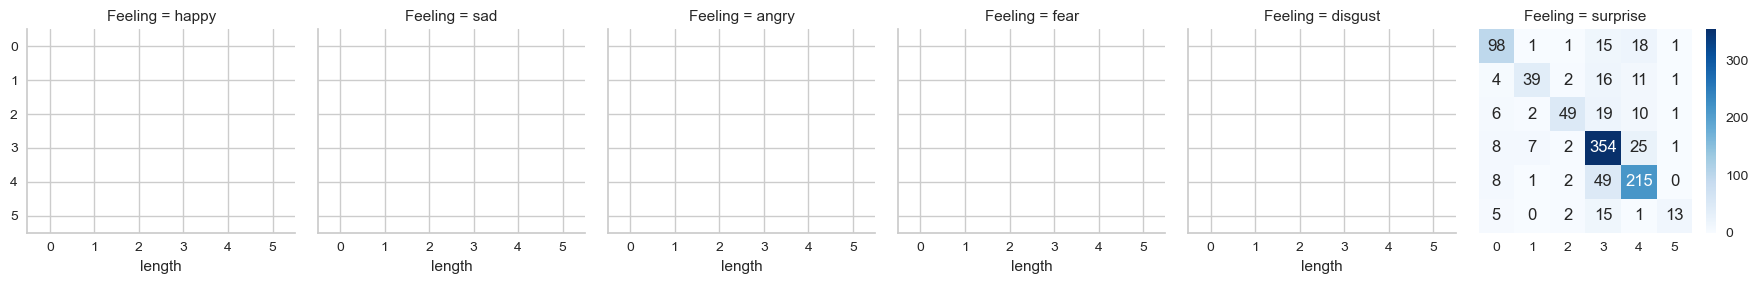

In [49]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, clf.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()


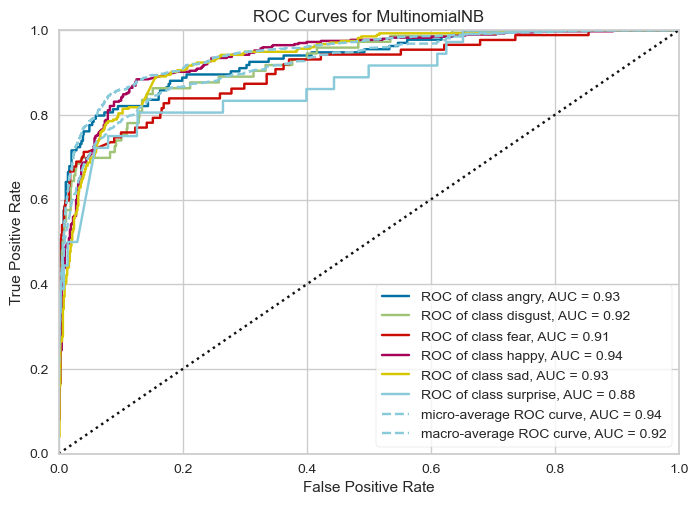

<AxesSubplot:title={'center':'ROC Curves for MultinomialNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [50]:
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

from yellowbrick.classifier import ROCAUC


visualizer = ROCAUC(clf, classes=['angry' ,'disgust', 'fear', 'happy' ,'sad' ,'surprise'])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and render the figure




# SVM

In [25]:
#SVM


# Create the parameter grid based on the results of random search
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

# Create a based model
svc = SVC()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = svc, param_grid = param_grid,
                            cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_



Fitting 3 folds for each of 25 candidates, totalling 75 fits


c:\Users\themi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
2 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\themi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\themi\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 190, in fit
    X, y = self._validate_data(
  File "c:\Users\themi\anaconda3\lib\site-packages\sklearn\base.py", line 581, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "c:\Users\themi\anaconda3\lib\site-package

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

In [51]:
#{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

#fit with best parameters
svc = SVC(C=10, gamma=0.01, kernel='rbf')
svc.fit(X_train, y_train)


SVC(C=10, gamma=0.01)

Accuracy: 0.8607784431137725
              precision    recall  f1-score   support

       angry       0.87      0.90      0.89       134
     disgust       0.91      0.88      0.90        73
        fear       0.93      0.74      0.82        87
       happy       0.81      0.93      0.87       397
         sad       0.92      0.79      0.85       275
    surprise       0.75      0.58      0.66        36

    accuracy                           0.86      1002
   macro avg       0.86      0.80      0.83      1002
weighted avg       0.86      0.86      0.85      1002



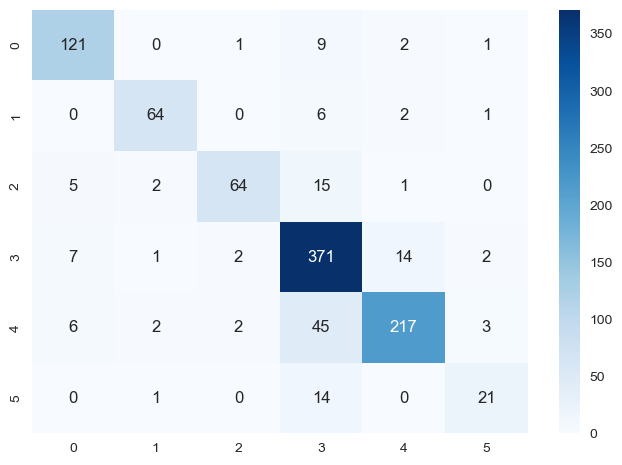

In [52]:
# predict the validation set
y_pred = svc.predict(X_valid)

# accuracy of the model
print("Accuracy:",accuracy_score(y_valid, y_pred))

# predict the test set
y_pred = svc.predict(X_test)

#classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, svc.predict(X_test)))

#plot confusion matrix


cm = confusion_matrix(y_test, svc.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()


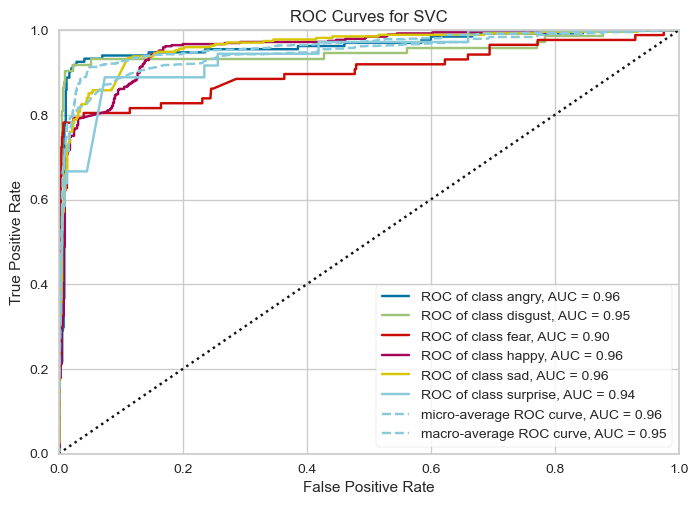

<AxesSubplot:title={'center':'ROC Curves for SVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [53]:
visualizer = ROCAUC(svc, classes=['angry' ,'disgust', 'fear', 'happy' ,'sad' ,'surprise'])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and render the figure

# Logistic Regression

In [54]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

# Create the parameter grid based on the results of random search
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2']
}

# Create a based model
logreg = LogisticRegression()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = logreg, param_grid = param_grid,
                            cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_



Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\themi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\themi\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\themi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\themi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
Valu

{'C': 1, 'penalty': 'l2'}

In [55]:
#{'C': 1, 'penalty': 'l2'}

#fit with best parameters
logreg = LogisticRegression(C=1, penalty='l2')
logreg.fit(X_train, y_train)


LogisticRegression(C=1)

Accuracy: 0.8592814371257484
              precision    recall  f1-score   support

       angry       0.91      0.89      0.90       134
     disgust       0.98      0.88      0.93        73
        fear       0.97      0.75      0.84        87
       happy       0.82      0.94      0.88       397
         sad       0.88      0.83      0.85       275
    surprise       0.88      0.64      0.74        36

    accuracy                           0.87      1002
   macro avg       0.91      0.82      0.86      1002
weighted avg       0.88      0.87      0.87      1002



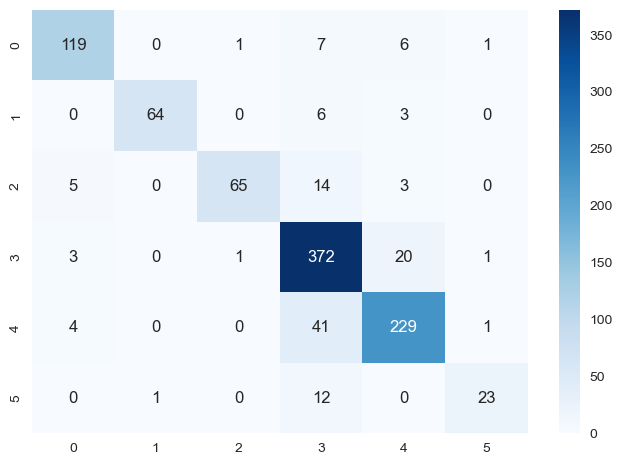

In [56]:
# predict the validation set
y_pred = logreg.predict(X_valid)

# accuracy of the model
print("Accuracy:",accuracy_score(y_valid, y_pred))

# predict the test set
y_pred = logreg.predict(X_test)

#classification report
print(classification_report(y_test, logreg.predict(X_test)))

#plot confusion matrix
cm = confusion_matrix(y_test, logreg.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()


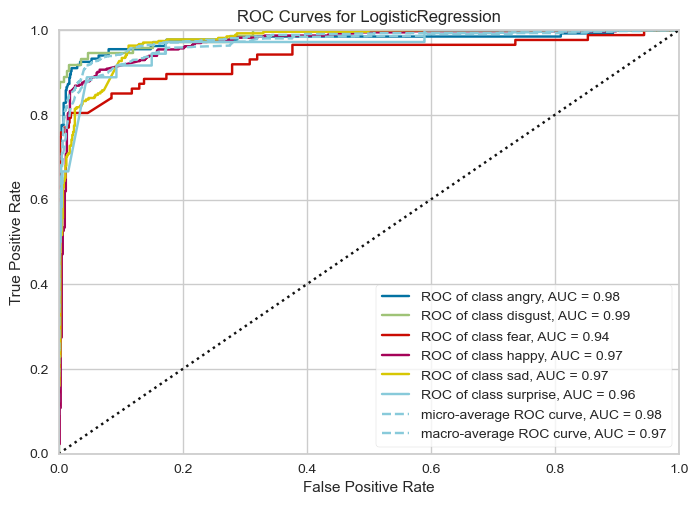

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [57]:
visualizer = ROCAUC(logreg, classes=['angry' ,'disgust', 'fear', 'happy' ,'sad' ,'surprise'])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and render the figure

In [20]:
# Create the parameter grid based on the results of random search
param_grid = {
    'max_depth': [10, 20, 50, 80, 100],
    'max_features': ['auto', 'sqrt'],
    'n_estimators': [200, 400, 800, 1000]
}

# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                            cv = 3, n_jobs = -1, verbose = 10)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_



Fitting 3 folds for each of 40 candidates, totalling 120 fits


: 

In [22]:
# {'max_depth': 100, 'max_features': 'auto', 'n_estimators': 200}

#fit with best parameters
rf = RandomForestClassifier(max_depth=100, max_features='auto', n_estimators=200)
rf.fit(X_train, y_train)


RandomForestClassifier(max_depth=100, n_estimators=200)

Accuracy: 0.8507984031936128
              precision    recall  f1-score   support

       angry       0.93      0.87      0.90       134
     disgust       1.00      0.82      0.90        73
        fear       0.97      0.72      0.83        87
       happy       0.77      0.97      0.86       397
         sad       0.94      0.78      0.85       275
    surprise       0.96      0.61      0.75        36

    accuracy                           0.86      1002
   macro avg       0.93      0.80      0.85      1002
weighted avg       0.88      0.86      0.86      1002



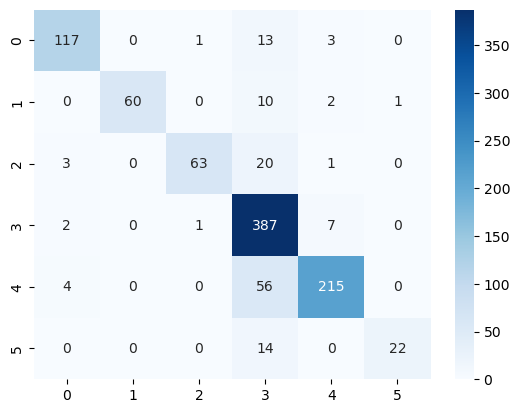

In [30]:
# predict the validation set
y_pred = rf.predict(X_valid)

# accuracy of the model
print("Accuracy:",accuracy_score(y_valid, y_pred))

# predict the test set
y_pred = rf.predict(X_test)

#classification report
print(classification_report(y_test, rf.predict(X_test)))

#plot confusion matrix
cm = confusion_matrix(y_test, rf.predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()


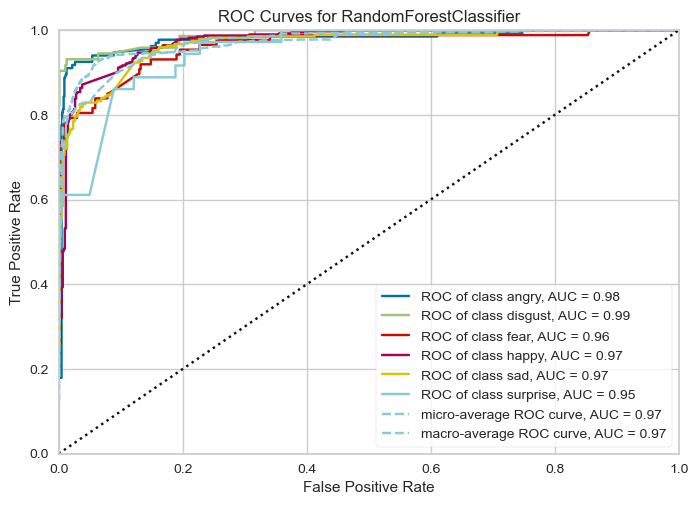

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [33]:
visualizer = ROCAUC(rf, classes=['angry' ,'disgust', 'fear', 'happy' ,'sad' ,'surprise'])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and render the figure